In [120]:
## Package management

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

pd.options.display.float_format = '{:,.6f}'.format
np.set_printoptions(suppress=True)
pd.options.display.max_seq_items = 2000
pd.options.display.max_rows = 4000

## SIS MODEL SIMULATION

In [121]:
def sis_model(G, gamma, beta, num_iterations, infected_percent):
    # Initialize the number of infected and susceptible nodes
    n = len(G)
    infected = np.random.binomial(1, infected_percent, size=n)
    adj_matrix = nx.to_numpy_array(G)
    adj_matrix_in_time = np.zeros((num_iterations, n), dtype=bool)
    adj_matrix_in_time[0,:] = infected

    # Iterate for the specified number of iterations
    for t in range(1, num_iterations):
        # Compute the transition probabilities for each node
        previous_state = adj_matrix_in_time[t-1,:]
        mask = np.matrix(np.split(np.random.binomial(1, beta, size=n*n), n))
        infected = np.dot(np.multiply(mask, adj_matrix), previous_state) > 0
        recovered = np.random.binomial(1, gamma, size=n) * previous_state
        adj_matrix_in_time[t,:] = (previous_state | infected) & ~recovered

    # Return the infected and susceptible lists
    infected_list = np.sum(adj_matrix_in_time, axis=1)
    susceptible_list = n - infected_list
    return infected_list, susceptible_list


## TASK 1  RESULTS

In [122]:
graphs_names = [
    "Complete",
    "Scale-Free", 
    "Small-World",
    "Star",
    "Regular Lattice",
    "Erdos-Renyi"
]
graphs = []
for name in graphs_names:
	if name == 'Complete':
		graphs.append(nx.complete_graph(1000))
	elif name == 'Scale-Free':
		graphs.append(nx.barabasi_albert_graph(1000, 3))
	elif name == 'Small-World':
		graphs.append(nx.watts_strogatz_graph(1000, 10, 0.5))
	elif name == 'Star':
		graphs.append(nx.star_graph(1000))
	elif name == 'Regular Lattice':
		graphs.append(nx.grid_graph(dim=[30, 30]))
	elif name == 'Erdos-Renyi':
		graphs.append(nx.erdos_renyi_graph(1000, 0.1))

In [123]:
def plot_sis_model(graphs_names,graphs, gamma, beta, num_iterations, infected_percent):
    
    for i, G in enumerate(graphs):
        # Simulate the spread of the disease on the current graph
        infected, susceptible = sis_model(G, gamma, beta, num_iterations, infected_percent)
        plt.figure()
        plt.plot([x / len(G) for x in infected], label='Infected')
        #plt.plot(susceptible, label='Susceptible')
        plt.title(f'SIS Model on {graphs_names[i]} Graph')
        plt.xlabel('Time step')
        plt.ylabel('Infected fraction')
        plt.legend()


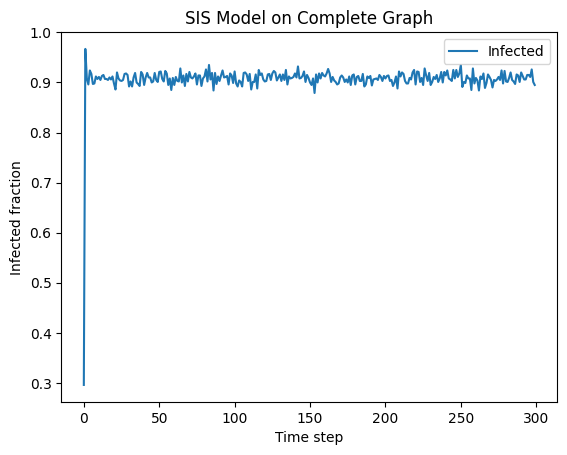

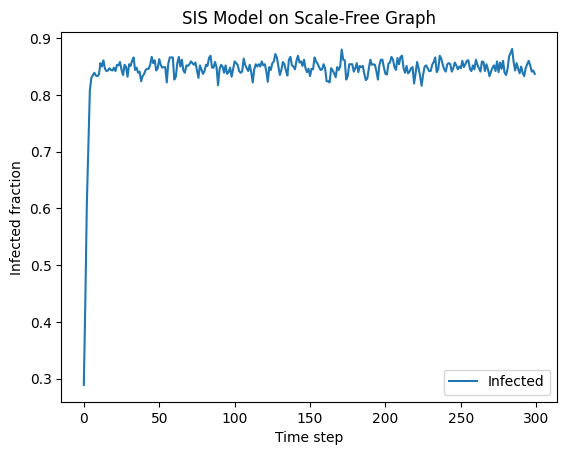

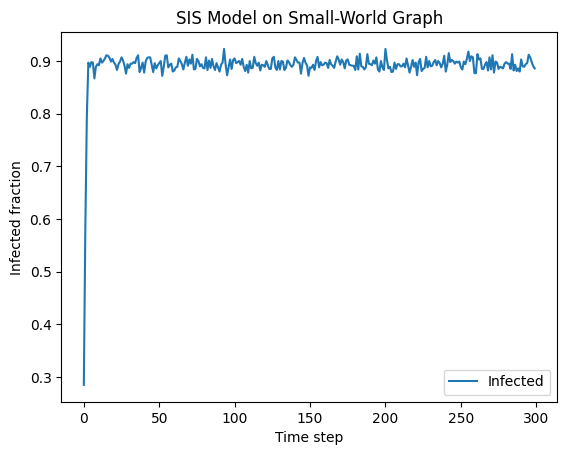

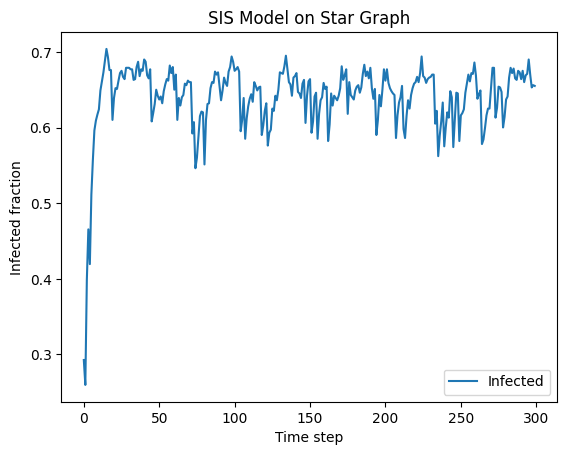

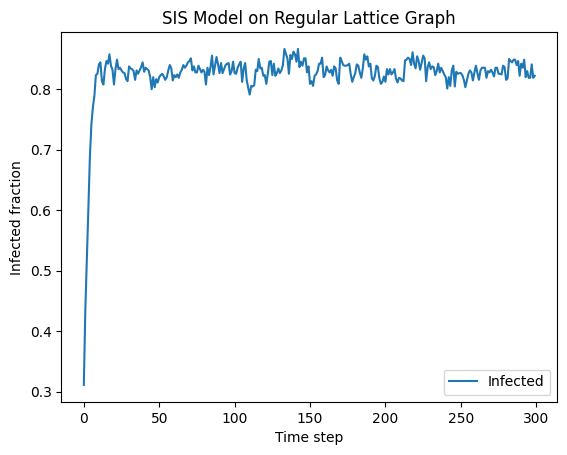

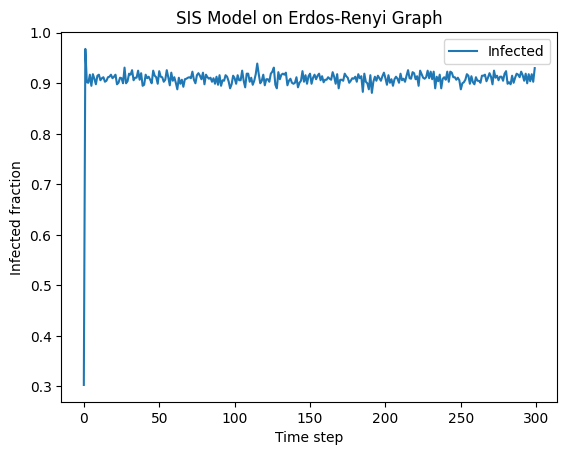

In [124]:
plot_sis_model(graphs_names, graphs, gamma=0.1, beta=0.2, num_iterations=300, infected_percent=0.3)

### TASK 2 

In [125]:
# get eigen values
import pandas as pd

def get_eigenvalues(graphs_names, graphs):
    rows = []
    for i, G in enumerate(graphs):
        eigenvalues = nx.linalg.adjacency_spectrum(G)
        max_eigenvalue = max(eigenvalues)
        row = {'Graph': graphs_names[i], 'Eigenvalues': eigenvalues, 'Max Eigenvalue': max_eigenvalue}
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=['Graph', 'Eigenvalues', 'Max Eigenvalue'])
    return df

df = get_eigenvalues(graphs_names, graphs)



/usr/local/lib/python3.10/site-packages/networkx/linalg/spectrum.py:110: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return sp.linalg.eigvals(nx.adjacency_matrix(G, weight=weight).todense())


In [126]:
df

,Graph,Eigenvalues,Max Eigenvalue
0,Complete,"[(999.0000000000059+0j), (-0.9999999999998808+...",999.000000+0.000000j
1,Scale-Free,"[(15.489989522203752+0j), (-12.095642101800962...",15.489990+0.000000j
2,Small-World,"[(10.394424950951382+0j), (7.259121195461698+0...",10.394425+0.000000j
3,Star,"[(31.62277660168374+0j), (-31.622776601683732+...",31.622777+0.000000j
4,Regular Lattice,"[(3.97947729356758+0j), (3.918119765009967+0j)...",3.979477+0.000000j
5,Erdos-Renyi,"[(100.98831297970463+0j), (18.770405012707812+...",100.988313+0.000000j


## Get threshold


In [127]:
def find_threshold_beta(G, gamma):
    # Compute the maximum eigenvalue of the adjacency matrix
    max_eigenvalue = max(nx.linalg.adjacency_spectrum(G))
    # Compute the threshold
    beta = gamma / max_eigenvalue 
    return beta

/usr/local/lib/python3.10/site-packages/networkx/linalg/spectrum.py:110: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return sp.linalg.eigvals(nx.adjacency_matrix(G, weight=weight).todense())
/var/folders/n5/ktlz2xtn5vs65v3vw81n10k80000gn/T/ipykernel_40018/4277549394.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  mask = np.matrix(np.split(np.random.binomial(1, beta, size=n*n), n))
/usr/local/lib/python3.10/site-packages/networkx/linalg/spectrum.py:110: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return sp.linalg.eigvals(nx.adjacency_matrix(G, weight=weight).todense())
/var/folders/n5/ktlz2xtn5vs65v3vw81n10k80000gn/T/ipykernel_40018/4277549394.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  mask = np.matrix(np.split(np.random.binomial(1, beta, size=n*n), n))
/usr/local/lib/python3.10/site-packages/

,Graph,gamma,beta_thresh,beta_above,beta_below
0,Complete,0.100000,0.000100+0.000000j,0.000140+0.000000j,0.000060+0.000000j
1,Scale-Free,0.100000,0.006456+0.000000j,0.009038+0.000000j,0.003873+0.000000j
2,Small-World,0.100000,0.009621+0.000000j,0.013469+0.000000j,0.005772+0.000000j
3,Star,0.100000,0.003162+0.000000j,0.004427+0.000000j,0.001897+0.000000j
4,Regular Lattice,0.100000,0.025129+0.000000j,0.035180+0.000000j,0.015077+0.000000j
5,Erdos-Renyi,0.100000,0.000990+0.000000j,0.001386+0.000000j,0.000594+0.000000j


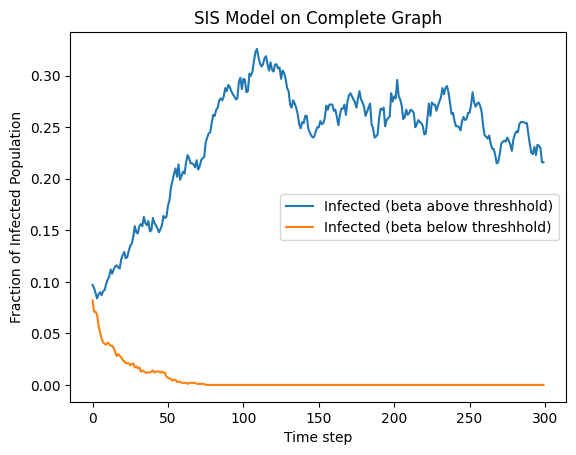

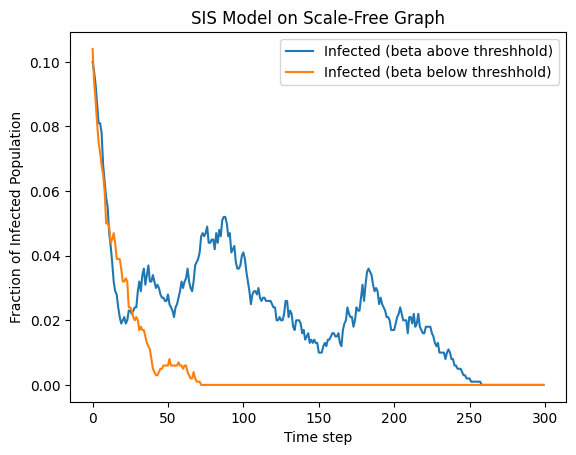

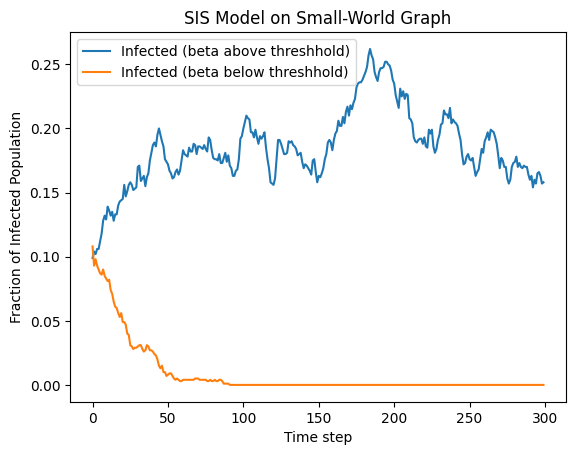

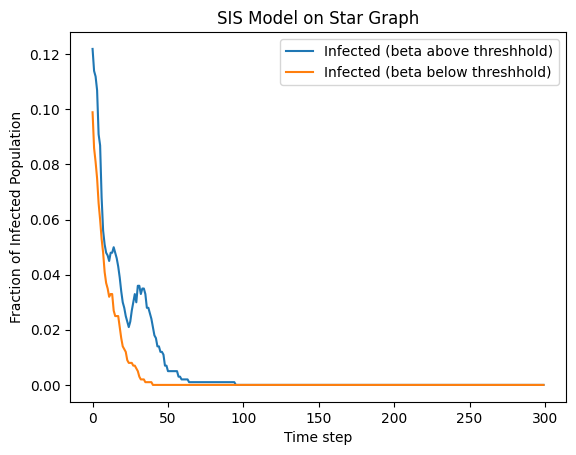

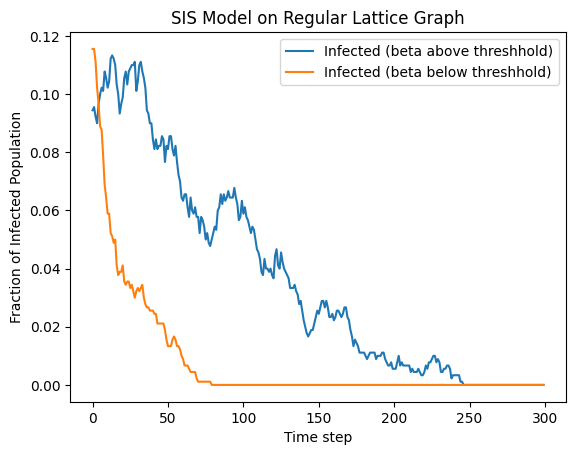

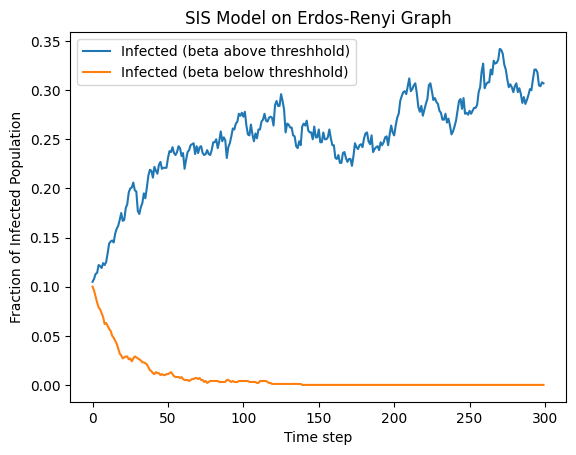

In [129]:
rows = []
for i, G in enumerate(graphs):
    
    df = pd.DataFrame(rows, columns=['Graph', 'Eigenvalues', 'Max Eigenvalue'])
    gamma = 0.1
    epsilon = 0.4
    # Compute the threshold
    beta_threshold = find_threshold_beta(G, gamma)
    beta_slightly_above = min(1,beta_threshold*(1+epsilon))
    beta_slightly_below = max(0,beta_threshold*(1-epsilon))
    # Simulate the SIS model with beta and gamma slightly above the threshold
    infected, susceptible = sis_model(G, gamma, beta_slightly_above, num_iterations=300, infected_percent=gamma)
	# Simulate the SIS model with beta and gamma slightly below the threshold
    infected2, susceptible2 = sis_model(G, gamma, beta_slightly_below, num_iterations=300, infected_percent=gamma)
    plt.figure()
    plt.plot([x/len(G) for x in infected], label='Infected (beta above threshhold)')
    plt.plot([x/len(G) for x in infected2], label='Infected (beta below threshhold)')
    plt.title(f'SIS Model on {graphs_names[i]} Graph')
    plt.xlabel('Time step')
    plt.ylabel('Fraction of Infected Population')
    plt.legend()
    
    row = {'Graph': graphs_names[i], 'gamma': gamma, 'beta_thresh': beta_threshold, 'beta_above': beta_slightly_above, 'beta_below': beta_slightly_below}
    rows.append(row)
 
df = pd.DataFrame(rows, columns=['Graph', 'gamma', 'beta_thresh','beta_above','beta_below'])
df